In [30]:
def convert_loom_to_anndata(loom_file, ca_list=[], ra_list=[], ca_index='CellID', ra_index='Accession'):
    attr_lists = [ca_list, ra_list]
    
    # if attr lists are empy, keep original columns/rows
    for idx, attr_list in enumerate(attr_lists):
        if len(attr_lists[idx]) == 0:
            if idx == 0: 
                attr_lists[idx] = loom_file.ca.keys()
            elif idx == 1: 
                attr_lists[idx] = loom_file.ra.keys()
    
    # select index columns for the dataframes
    attr_indexes = [ca_index, ra_index]
    for idx, index in enumerate(attr_indexes):
        if type(index) == int:
            attr_indexes[idx] = attr_lists[idx][index]
        elif type(index) == str:
            assert index in attr_lists[idx]
    print(f'The indeces for var and obs will be assigned to {attr_indexes[0]} and {attr_indexes[1]}')
    
    # create var and obs dataframes with defined columns and indexes (indices)
    ad_attr = [pd.DataFrame(), pd.DataFrame()]
    for idx, attr_list in enumerate(attr_lists):
        for attr in attr_list:
            if idx == 0: 
                ad_attr[idx][attr] = loom_file.ca[attr]
            elif idx == 1: 
                ad_attr[idx][attr] = loom_file.ra[attr]
        ad_attr[idx].index = ad_attr[idx][attr_indexes[idx]]

    adata = ad.AnnData(X = loom_file[:, :].T, var=ad_attr[1], obs=ad_attr[0])
        
    return adata

In [36]:
import pickle
from datetime import date
import os
import loompy
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
from src.classes import *

In [32]:
today = date.today()
print(today)

input_folder = '../../data/sc_data/mouse_sc/original/Linnarsson_mouse_brain_all/'

output_path = '../../data/sc_data/mouse_sc/'
output_folder = f'{output_path}L5_{today.strftime("%d%m%y")}/'
print(output_folder)
os.makedirs(output_folder, exist_ok=True)

2022-12-01
../../data/sc_data/mouse_sc/L5_011222/


In [33]:
# if you have problems with loading a package, check  if it is installed in the environment
!conda list | grep "loompy"

loompy                    3.0.7                    pypi_0    pypi


In [ ]:
pickle_loc = '/media/Dropbox/MNM projects/Spatial transcriptomics project/Data analysis/Complete_ST_pipeline/data/sc_data/mouse_sc/original/Linnarsson_mouse_brain_all/L5_all_subset_notation.pkl'

In [40]:
if not os.path.isfile(pickle_loc):
    print('Creating Anndata from the original loom file')
    L5_all = loompy.connect(f'{input_folder}L5_All.loom')
    ca_selection = ['Age', 'AnalysisPool', 'CellID', 'Class', 'ClusterName', 'Description', 'Location_based_on',                         'Mean Reads per Cell', 'Median UMI Counts per Cell', 'Neurotransmitter', 'Region',
                             'TaxonomyRank1', 'TaxonomyRank2', 'TaxonomyRank3', 'TaxonomyRank4', 'bio_celltype', 'ChipID',
                    'SampleID', 'SampleIndex', 'PCRCycles', 'Strain']
    ra_selection = ['Accession', 'Gene', 'Gene_no_alt']
    adata_all = convert_loom_to_anndata(L5_all, ca_list=ca_selection, ra_list=ra_selection)
    L5_all.close()
    # save pickle if you want
    with open(pickle_loc, 'wb') as pickle_file:
        pickle.dump(adata_all, pickle_file)
else:
    print('loading saved pickle')
    with open(pickle_loc, 'rb') as pickle_file:
        adata_all = pickle.load(pickle_file)
    
adata_all

AnnData object with n_obs × n_vars = 160796 × 27998
    obs: 'Age', 'AnalysisPool', 'CellID', 'Class', 'ClusterName', 'Description', 'Location_based_on', 'Mean Reads per Cell', 'Median UMI Counts per Cell', 'Neurotransmitter', 'Region', 'TaxonomyRank1', 'TaxonomyRank2', 'TaxonomyRank3', 'TaxonomyRank4', 'bio_celltype', 'ChipID', 'SampleID', 'SampleIndex', 'PCRCycles', 'Strain'
    var: 'Accession', 'Gene', 'Gene_no_alt'

In [6]:
# These are all the availabel cell annotations from TaxonomyRank4 (a sweetspot in between too much and too little description...)
adata_all.obs['TaxonomyRank4'].value_counts()

Oligodendrocytes                               30253
Astrocytes                                     19377
Telencephalon projecting excitatory neurons    18799
Enteric glia                                   10535
Telencephalon inhibitory interneurons           8637
Di- and mesencephalon excitatory neurons        6455
Telencephalon projecting inhibitory neurons     5691
Microglia                                       5425
Cerebellum neurons                              5292
Pericytes                                       5213
Olfactory inhibitory neurons                    5191
Non-glutamatergic neuroblasts                   4822
Dentate gyrus granule neurons                   4368
Di- and mesencephalon inhibitory neurons        4026
Vascular endothelial cells                      3805
Peptidergic neurons                             2906
Olfactory ensheathing cells                     2031
Perivascular macrophages                        2029
Vascular smooth muscle cells                  

In [41]:
# merge astrocytes and separate dopaminergic clusters
# clusters that we want to focus on
celltypes_to_keep_dict  = {
    'MBDOP2': 'Dopaminergic neurons, SN, VTA; mouse' , 
    'MBDOP1': 'Dopaminergic neurons, periaqueductal grey; mouse' , 
    'MOL1': 'Oligodendrocytes',
    'COP1': 'Oligodendrocytes',
    'MFOL1': 'Oligodendrocytes',
    'MFOL2': 'Oligodendrocytes',
    'MSN1': 'D1 Medium Spiny Neurons; mouse',
    'MSN2': 'D2 Medium Spiny Neurons; mouse',
    'MSN3': 'D2 Medium Spiny Neurons; mouse',
    'MSN4': 'D1 Medium Spiny Neurons; mouse',
    'MSN5': 'D1/D2 Medium Spiny Neurons, striatum',
    'MSN6': 'D1 Medium Spiny Neurons; mouse',
    'TEGLU1': 'Cortical projection neurons; mouse',
    'TEGLU2': 'Cortical projection neurons; mouse',
    'TEGLU3': 'Cortical projection neurons; mouse',
    'TEGLU4': 'Cortical projection neurons; mouse',
    'TEGLU5': 'Cortical projection neurons; mouse',
    'TEGLU6': 'Cortical projection neurons; mouse',
    'TEGLU7': 'Cortical projection neurons; mouse',
    'TEGLU8': 'Cortical projection neurons; mouse',
    'TEGLU9': 'Cortical projection neurons; mouse',
    'TEGLU10': 'Cortical projection neurons; mouse',
    'TEGLU11': 'Cortical projection neurons; mouse',
    'TEGLU12': 'Cortical projection neurons; mouse',
    'TEGLU13': 'Cortical projection neurons; mouse',
    'TEGLU14': 'Cortical projection neurons; mouse',
    'TEGLU15': 'Cortical projection neurons; mouse',
    'TEGLU16': 'Cortical projection neurons; mouse',
    'TEGLU17': 'Cortical projection neurons; mouse',
    'TEGLU18': 'Cortical projection neurons; mouse',
    'TEGLU19': 'Cortical projection neurons; mouse',
    'TEGLU20': 'Cortical projection neurons; mouse',
    'TECHO': 'Cholinergic interneurons; mouse',
    'DECHO1': 'Cholinergic interneurons; mouse',
    'VLMC1': 'Vascular leptomeningeal cells; mouse',
    'VLMC2': 'Vascular leptomeningeal cells; mouse',
    'ABC': 'Vascular leptomeningeal cells; mouse',
    'ACTE1': 'Astrocytes; mouse',
    'ACTE2': 'Astrocytes; mouse',
    'ACMB': 'Astrocytes; mouse',
    'ACNT1': 'Astrocytes; mouse',
    'ACNT2': 'Astrocytes; mouse',
    'VECA' : 'Vascular; mouse',
    'VSMCA' : 'Vascular; mouse',
    'PER1' : 'Vascular; mouse',
    'PER2' : 'Vascular; mouse',
    'PER3' : 'Vascular; mouse',
    'VECC' : 'Vascular; mouse',
    'VECV' : 'Vascular; mouse',
    'PVM1' : 'Immune cells; mouse',
    'PVM2' : 'Immune cells; mouse',
    'MGL3' : 'Immune cells; mouse',
    'MGL2' : 'Immune cells; mouse',
    'MGL1' : 'Immune cells; mouse',
    'RGDG' : 'Dentate gyrus radial glia-like cells',
    'RGSZ' : 'Subventricular zone radial glia-like cells',
    'SEPNBL' : 'Glutamatergic neuroblasts, pallidum; mouse'
}

celltypes_to_discard = ['Ependymal cells']
# supplemented by Taxonomy Rank 4 (or any other column) anotation
annotated_column, annotation_column = 'ClusterName', 'TaxonomyRank4'
annot_cluster = adata_all.obs[[annotated_column, annotation_column]]
annot_dict = annot_cluster.groupby(annotated_column).first().to_dict()[annotation_column]   

In [42]:
# merge astrocytes
# clusters that we want to focus on
celltypes_to_keep_dict  = {
    'MBDOP2': 'Dopaminergic neurons; mouse' , 
    'MBDOP1': 'Dopaminergic neurons; mouse' , 
    'MOL1': 'Oligodendrocytes',
    'COP1': 'Oligodendrocytes',
    'MFOL1': 'Oligodendrocytes',
    'MFOL2': 'Oligodendrocytes',
    'MSN1': 'D1 Medium Spiny Neurons; mouse',
    'MSN2': 'D2 Medium Spiny Neurons; mouse',
    'MSN3': 'D2 Medium Spiny Neurons; mouse',
    'MSN4': 'D1 Medium Spiny Neurons; mouse',
    'MSN5': 'D1/D2 Medium Spiny Neurons, striatum',
    'MSN6': 'D1 Medium Spiny Neurons; mouse',
    'TEGLU1': 'Cortical projection neurons; mouse',
    'TEGLU2': 'Cortical projection neurons; mouse',
    'TEGLU3': 'Cortical projection neurons; mouse',
    'TEGLU4': 'Cortical projection neurons; mouse',
    'TEGLU5': 'Cortical projection neurons; mouse',
    'TEGLU6': 'Cortical projection neurons; mouse',
    'TEGLU7': 'Cortical projection neurons; mouse',
    'TEGLU8': 'Cortical projection neurons; mouse',
    'TEGLU9': 'Cortical projection neurons; mouse',
    'TEGLU10': 'Cortical projection neurons; mouse',
    'TEGLU11': 'Cortical projection neurons; mouse',
    'TEGLU12': 'Cortical projection neurons; mouse',
    'TEGLU13': 'Cortical projection neurons; mouse',
    'TEGLU14': 'Cortical projection neurons; mouse',
    'TEGLU15': 'Cortical projection neurons; mouse',
    'TEGLU16': 'Cortical projection neurons; mouse',
    'TEGLU17': 'Cortical projection neurons; mouse',
    'TEGLU18': 'Cortical projection neurons; mouse',
    'TEGLU19': 'Cortical projection neurons; mouse',
    'TEGLU20': 'Cortical projection neurons; mouse',
    'TECHO': 'Cholinergic interneurons; mouse',
    'DECHO1': 'Cholinergic interneurons; mouse',
    'VLMC1': 'Vascular leptomeningeal cells; mouse',
    'VLMC2': 'Vascular leptomeningeal cells; mouse',
    'ABC': 'Vascular leptomeningeal cells; mouse',
    'ACTE1': 'Astrocytes; mouse',
    'ACTE2': 'Astrocytes; mouse',
    'ACMB': 'Astrocytes; mouse',
    'ACNT1': 'Astrocytes; mouse',
    'ACNT2': 'Astrocytes; mouse',
    'VECA' : 'Vascular; mouse',
    'VSMCA' : 'Vascular; mouse',
    'PER1' : 'Vascular; mouse',
    'PER2' : 'Vascular; mouse',
    'PER3' : 'Vascular; mouse',
    'VECC' : 'Vascular; mouse',
    'VECV' : 'Vascular; mouse',
    'PVM1' : 'Immune cells; mouse',
    'PVM2' : 'Immune cells; mouse',
    'MGL3' : 'Immune cells; mouse',
    'MGL2' : 'Immune cells; mouse',
    'MGL1' : 'Immune cells; mouse',
    'RGDG' : 'Dentate gyrus radial glia-like cells',
    'RGSZ' : 'Subventricular zone radial glia-like cells',
    'SEPNBL' : 'Glutamatergic neuroblasts, pallidum; mouse'
#     ,
#     'TEINH2': 'Inhibitory neurons, septal nucleus',
#     'MEINH1': 'Inhibitory neurons, midbrain',
#     'MEINH14': 'Inhibitory neurons, midbrain'
}

celltypes_to_discard = ['Ependymal cells']
# supplemented by Taxonomy Rank 4 (or any other column) anotation
annotated_column, annotation_column = 'ClusterName', 'TaxonomyRank4'
annot_cluster = adata_all.obs[[annotated_column, annotation_column]]
annot_dict = annot_cluster.groupby(annotated_column).first().to_dict()[annotation_column]

In [43]:
adata_all.obs['Celltype_assigned'] = adata_all.obs['ClusterName'].replace(celltypes_to_keep_dict).replace(annot_dict)
adata_all.obs['Celltype_assigned'].value_counts(sort=True)

Oligodendrocytes                               30253
Astrocytes; mouse                              17018
Cortical projection neurons; mouse             15216
Vascular; mouse                                10646
Enteric glia                                   10535
Telencephalon inhibitory interneurons           8637
Immune cells; mouse                             7454
Di- and mesencephalon excitatory neurons        6455
Cerebellum neurons                              5292
Olfactory inhibitory neurons                    5191
Non-glutamatergic neuroblasts                   4822
Dentate gyrus granule neurons                   4368
Di- and mesencephalon inhibitory neurons        4026
Telencephalon projecting excitatory neurons     3583
D1 Medium Spiny Neurons; mouse                  2978
Peptidergic neurons                             2906
Astrocytes                                      2359
D2 Medium Spiny Neurons; mouse                  2341
Olfactory ensheathing cells                   

adata_all = merge_gene_symbol_duplicates(adata_all, symbol_column='Gene_no_alt')
adata_all.var.index = adata_all.var['Gene_no_alt']
adata_all.var.index.name = 'symbol'
adata_all.var

### Regions included in the dataset

Here we select, which regions do we want to have included in the dataset.
In my case, I chose all regions with striatum, cortex, midbrain, 'CNS' and Pallidum

In [44]:
selected_regions = ['Striatum', 'Midbrain ventral', 'Cortex', 'CNS']
adata_selected = adata_all[adata_all.obs['Region'].str.contains('|'.join(selected_regions)) | 
                           adata_all.obs['ClusterName'].str.contains('|'.join(celltypes_to_keep_dict.keys())) , :]
# adata_selected = adata_selected[adata_selected.obs['Celltype_assigned'] != 'Ependymal cells', :]
adata_selected

View of AnnData object with n_obs × n_vars = 104246 × 27998
    obs: 'Age', 'AnalysisPool', 'CellID', 'Class', 'ClusterName', 'Description', 'Location_based_on', 'Mean Reads per Cell', 'Median UMI Counts per Cell', 'Neurotransmitter', 'Region', 'TaxonomyRank1', 'TaxonomyRank2', 'TaxonomyRank3', 'TaxonomyRank4', 'bio_celltype', 'ChipID', 'SampleID', 'SampleIndex', 'PCRCycles', 'Strain', 'Celltype_assigned'
    var: 'Accession', 'Gene', 'Gene_no_alt'

In [45]:
del adata_all

In [46]:
adata_selected.obs['Celltype_assigned'].value_counts(sort=True)

Oligodendrocytes                               30253
Astrocytes; mouse                              17018
Cortical projection neurons; mouse             15216
Vascular; mouse                                10646
Telencephalon inhibitory interneurons           7542
Immune cells; mouse                             7454
Telencephalon projecting excitatory neurons     3583
D1 Medium Spiny Neurons; mouse                  2978
D2 Medium Spiny Neurons; mouse                  2341
Vascular leptomeningeal cells; mouse            1501
Peptidergic neurons                             1360
Non-glutamatergic neuroblasts                    971
Oligodendrocyte precursor cells                  820
Subventricular zone radial glia-like cells       756
Di- and mesencephalon inhibitory neurons         531
D1/D2 Medium Spiny Neurons, striatum             372
Dentate gyrus radial glia-like cells             327
Cholinergic interneurons; mouse                  235
Dopaminergic neurons; mouse                   

In [47]:
# This makes it a “real” AnnData object
adata_selected.obs["value"] = 0 

/tmp/ipykernel_121665/4040885219.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_selected.obs["value"] = 0
/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [48]:
adata_selected = merge_gene_symbol_duplicates(adata_selected, symbol_column='Gene_no_alt')
adata_selected.var.index = adata_selected.var['Gene_no_alt']
adata_selected.var.index.name = 'symbol'
adata_selected.var

Scaled from 27998 genes incl. alternative splicing to 27794 genes without alternative splicing variants


/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


,Accession,Gene,Gene_no_alt,value
symbol,,,,
0610007P14RIK,ENSMUSG00000021252,0610007P14Rik,0610007P14RIK,0
0610009B22RIK,ENSMUSG00000007777,0610009B22Rik,0610009B22RIK,0
0610009L18RIK,ENSMUSG00000043644,0610009L18Rik,0610009L18RIK,0
0610009O20RIK,ENSMUSG00000024442,0610009O20Rik,0610009O20RIK,0
0610010F05RIK,ENSMUSG00000042208,0610010F05Rik,0610010F05RIK,0
...,...,...,...,...
ZYG11A,ENSMUSG00000034645,Zyg11a,ZYG11A,0
ZYG11B,ENSMUSG00000034636,Zyg11b,ZYG11B,0
ZYX,ENSMUSG00000029860,Zyx,ZYX,0


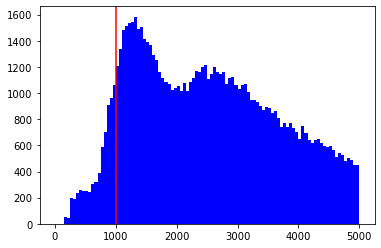

Oligodendrocytes                               30253
Astrocytes; mouse                              17018
Cortical projection neurons; mouse             15216
Vascular; mouse                                10646
Telencephalon inhibitory interneurons           7542
Immune cells; mouse                             7454
Telencephalon projecting excitatory neurons     3583
D1 Medium Spiny Neurons; mouse                  2978
D2 Medium Spiny Neurons; mouse                  2341
Vascular leptomeningeal cells; mouse            1501
Peptidergic neurons                             1360
Non-glutamatergic neuroblasts                    971
Oligodendrocyte precursor cells                  820
Subventricular zone radial glia-like cells       756
Di- and mesencephalon inhibitory neurons         531
D1/D2 Medium Spiny Neurons, striatum             372
Dentate gyrus radial glia-like cells             327
Cholinergic interneurons; mouse                  235
Dopaminergic neurons; mouse                   

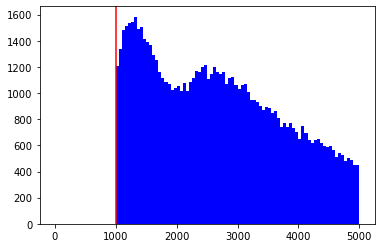

Oligodendrocytes                               30253
Cortical projection neurons; mouse             15123
Astrocytes; mouse                              12977
Vascular; mouse                                 9880
Telencephalon inhibitory interneurons           7415
Immune cells; mouse                             6472
Telencephalon projecting excitatory neurons     3533
D1 Medium Spiny Neurons; mouse                  2827
D2 Medium Spiny Neurons; mouse                  2321
Peptidergic neurons                             1311
Vascular leptomeningeal cells; mouse            1231
Non-glutamatergic neuroblasts                    864
Oligodendrocyte precursor cells                  820
Subventricular zone radial glia-like cells       564
Di- and mesencephalon inhibitory neurons         524
D1/D2 Medium Spiny Neurons, striatum             365
Dentate gyrus radial glia-like cells             276
Cholinergic interneurons; mouse                  235
Glutamatergic neuroblasts, pallidum; mouse    

In [49]:
# filter cells by transcript numbers
min_transcripts = 1000

adata_selected.obs['n_transcripts'] = np.sum(adata_selected.X, axis=1)

plt.hist(adata_selected.obs['n_transcripts'].to_numpy(), bins=100, color='blue', range=(0,5000))
plt.axvline(min_transcripts, color='red')
plt.show()

print(adata_selected.obs['Celltype_assigned'].value_counts())

adata_selected_filt = adata_selected[adata_selected.obs['n_transcripts'] >= min_transcripts, :]

plt.hist(adata_selected_filt.obs['n_transcripts'].to_numpy(), bins=100, color='blue', range=(0,5000))
plt.axvline(min_transcripts, color='red')
plt.show()

adata_selected_filt.obs['Celltype_assigned'].value_counts()

In [50]:
adata_selected_filt.obs_names_make_unique()

/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [51]:
# Number of cells coming from regions
print(adata_selected_filt.obs['Region'].value_counts())

# Number of different cell types in these regions
adata_selected_filt.obs['Celltype_assigned'].value_counts()

CNS                                                                                48656
Cortex                                                                             15123
Hippocampus,Cortex                                                                  7415
Telencephalon                                                                       6172
Hypothalamus,Thalamus,Midbrain dorsal,Midbrain ventral,Pons,Medulla,Spinal cord     5994
Striatum ventral                                                                    3576
Hippocampus                                                                         2597
Striatum dorsal                                                                     1937
Striatum dorsal, Striatum ventral                                                   1293
Amygdala                                                                             936
Striatum dorsal, Striatum ventral, Dentate gyrus                                     864
Midbrain dorsal      

Oligodendrocytes                               30253
Cortical projection neurons; mouse             15123
Astrocytes; mouse                              12977
Vascular; mouse                                 9880
Telencephalon inhibitory interneurons           7415
Immune cells; mouse                             6472
Telencephalon projecting excitatory neurons     3533
D1 Medium Spiny Neurons; mouse                  2827
D2 Medium Spiny Neurons; mouse                  2321
Peptidergic neurons                             1311
Vascular leptomeningeal cells; mouse            1231
Non-glutamatergic neuroblasts                    864
Oligodendrocyte precursor cells                  820
Subventricular zone radial glia-like cells       564
Di- and mesencephalon inhibitory neurons         524
D1/D2 Medium Spiny Neurons, striatum             365
Dentate gyrus radial glia-like cells             276
Cholinergic interneurons; mouse                  235
Glutamatergic neuroblasts, pallidum; mouse    

In [52]:
export_name = f'{output_folder}L5_CTX_M_STR_CNS_description_selection_1000_astmerged_Tax4'

In [53]:
adata_selected_filt.obs['Sample'] = 'Linnarsson'
adata_selected_filt.obs

,Age,AnalysisPool,CellID,Class,ClusterName,Description,Location_based_on,Mean Reads per Cell,Median UMI Counts per Cell,Neurotransmitter,...,bio_celltype,ChipID,SampleID,SampleIndex,PCRCycles,Strain,Celltype_assigned,value,n_transcripts,Sample
CellID,,,,,,,,,,,,,,,,,,,,,
10X53_4_GCAAACGGGATG-,p21-23,,10X53_4_GCAAACGGGATG-,Oligos,MOL3,"Mature oligodendrocytes, spinal cord enriched ...","Apold1,Cyp1b1",,,,...,Oligos,10X53,10X53_4,SI-3A-D11,13,Swiss,Oligodendrocytes,0,6135.0,Linnarsson
10X53_4_TTAACTCTTCTA-,p21-23,,10X53_4_TTAACTCTTCTA-,Oligos,MOL3,"Mature oligodendrocytes, spinal cord enriched ...","Apold1,Cyp1b1",,,,...,Oligos,10X53,10X53_4,SI-3A-D11,13,Swiss,Oligodendrocytes,0,5506.0,Linnarsson
10X53_4_ATGTTGCCAAGT-,p21-23,,10X53_4_ATGTTGCCAAGT-,Oligos,MOL3,"Mature oligodendrocytes, spinal cord enriched ...","Apold1,Cyp1b1",,,,...,Oligos,10X53,10X53_4,SI-3A-D11,13,Swiss,Oligodendrocytes,0,6966.0,Linnarsson
10X53_6_ATGCACTTCATC-,p21-23,,10X53_6_ATGCACTTCATC-,Oligos,MOL3,"Mature oligodendrocytes, spinal cord enriched ...","Apold1,Cyp1b1",,,,...,Oligos,10X53,10X53_6,SI-3A-F11,13,Swiss,Oligodendrocytes,0,14138.0,Linnarsson
10X52_7_CTAATGAGGGTG-,p20,,10X52_7_CTAATGAGGGTG-,Oligos,MOL3,"Mature oligodendrocytes, spinal cord enriched ...","Apold1,Cyp1b1",,,,...,Oligos,10X52,10X52_7,SI-3A-G10,13,CD-1,Oligodendrocytes,0,8491.0,Linnarsson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X20_4_CGCTAAGACGAATC-1,p22,,10X20_4_CGCTAAGACGAATC-1,Astrocytes,ACMB,Dorsal midbrain Myoc-expressing astrocyte-like,"Drd1,Tac1 and dissection region",,,,...,Astrocytes,10X20,10X20_4,SI-3A-D5,13,CD-1,Astrocytes; mouse,0,1019.0,Linnarsson
10X52_4_CATAGAGTCGTA-,p20,,10X52_4_CATAGAGTCGTA-,Astrocytes,ACMB,Dorsal midbrain Myoc-expressing astrocyte-like,"Drd1,Tac1 and dissection region",,,,...,Astrocytes,10X52,10X52_4,SI-3A-D10,13,CD-1,Astrocytes; mouse,0,2431.0,Linnarsson
10X57_3_TTGAACTAGACC-,p25-27,,10X57_3_TTGAACTAGACC-,Astrocytes,ACMB,Dorsal midbrain Myoc-expressing astrocyte-like,"Drd1,Tac1 and dissection region",,,,...,Astrocytes,10X57,10X57_3,SI-3A-H1,13,Swiss,Astrocytes; mouse,0,1635.0,Linnarsson


In [54]:
export_name

'../../data/sc_data/mouse_sc/L5_011222/L5_CTX_M_STR_CNS_description_selection_1000_astmerged_Tax4'

In [55]:
adata_selected_filt.write_h5ad(f'{export_name}.h5ad')

In [56]:
adata_selected_filt.write_loom(f'{export_name}.loom')

In [29]:
with open(f'{export_name}.pkl', 'wb') as export:
        pickle.dump(adata_selected_filt, export)

In [7]:
with open(f'{export_name}.pkl', 'rb') as imported:
    adata_selected_filt = pickle.load(imported)
adata_selected_filt

AnnData object with n_obs × n_vars = 97302 × 27794
    obs: 'Age', 'AnalysisPool', 'CellID', 'Class', 'ClusterName', 'Description', 'Location_based_on', 'Mean Reads per Cell', 'Median UMI Counts per Cell', 'Neurotransmitter', 'Region', 'TaxonomyRank1', 'TaxonomyRank2', 'TaxonomyRank3', 'TaxonomyRank4', 'bio_celltype', 'ChipID', 'SampleID', 'SampleIndex', 'PCRCycles', 'Strain', 'Celltype_assigned', 'value', 'n_transcripts', 'Sample'
    var: 'Accession', 'Gene', 'Gene_no_alt', 'value'
    uns: 'merged'

In [11]:
adata_selected_filt = adata_selected_filt[adata_selected_filt.obs['Celltype_assigned'] != 'Cerebellum neurons', :]

In [12]:
adata_selected_filt

View of AnnData object with n_obs × n_vars = 97274 × 27794
    obs: 'Age', 'AnalysisPool', 'CellID', 'Class', 'ClusterName', 'Description', 'Location_based_on', 'Mean Reads per Cell', 'Median UMI Counts per Cell', 'Neurotransmitter', 'Region', 'TaxonomyRank1', 'TaxonomyRank2', 'TaxonomyRank3', 'TaxonomyRank4', 'bio_celltype', 'ChipID', 'SampleID', 'SampleIndex', 'PCRCycles', 'Strain', 'Celltype_assigned', 'value', 'n_transcripts', 'Sample'
    var: 'Accession', 'Gene', 'Gene_no_alt', 'value'
    uns: 'merged'

In [10]:
def subsample_anndata(anndata, annot_column='Celltype_assigned', counts=[50, 5000000]):
    print(f'Dataset will be downsampled to contain between {counts[0]} and {counts[1]} cells per celltype')
    anndata_subset = anndata.copy()
    cells_to_keep = []

    for x in anndata_subset.obs[annot_column].unique():
        print(x)
        all_cells = anndata_subset.obs[anndata_subset.obs[annot_column] == x]['CellID'].to_list()
        if len(all_cells) < counts[0]:
            anndata_subset = anndata_subset[anndata_subset.obs[annot_column] != x, :]
            print(f'{x} with {len(all_cells)} cells will be dropped')
        elif len(all_cells) >= counts[0] and len(all_cells) <= counts[1]:
            cells_to_keep += all_cells
            print(f'All {len(all_cells)} cells will be used')
        elif len(all_cells) > counts[1]:
            cells_that_won_the_lottery = np.random.choice(all_cells, size=counts[1], replace=False).tolist()
            print(f'{len(cells_that_won_the_lottery)} cells will be kept out of {len(all_cells)}')
            cells_to_keep += cells_that_won_the_lottery
    
    anndata_subset = anndata_subset[anndata_subset.obs['CellID'].isin(cells_to_keep), :]
    print(anndata_subset.obs[annot_column].value_counts())
    
    return anndata_subset

In [45]:
adata_selected_subset = subsample_anndata(adata_selected_filt, annot_column='Celltype_assigned', counts=[50, 50000000000])

Dataset will be downsampled to contain between 50 and 500 cells per celltype
Oligodendrocytes
500 cells will be kept out of 16336
Cortical projection neurons; mouse
500 cells will be kept out of 14624
Excitatory neurons, amygdala
500 cells will be kept out of 871
Excitatory neurons, hippocampus CA3
All 455 cells will be used
Excitatory neurons, hippocampus CA1
500 cells will be kept out of 1978
R-LM border Cck interneurons, cortex/hippocampus
500 cells will be kept out of 1227
Non-border Cck interneurons, cortex/hippocampus
All 279 cells will be used
Interneuron-selective interneurons, cortex/hippocampus
500 cells will be kept out of 1071
CGE-derived neurogliaform cells Cxcl14+, cortex/hippocampus
All 383 cells will be used
Ivy and MGE-derived neurogliaform cells, cortex/hippocampus
500 cells will be kept out of 617
CGE-derived neurogliaform cells, cortex/hippocampus
500 cells will be kept out of 978
Hippocamposeptal projection, cortex/hippocampus
500 cells will be kept out of 1029
Sle

/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
# Plot UMAP for the subsampled dataset
adata_selected_subset.raw = adata_selected_subset.copy()
sc.pp.normalize_per_cell(adata_selected_subset)
sc.pp.log1p(adata_selected_subset)

In [12]:
sc.pp.neighbors(adata_selected_subset)
sc.tl.pca(adata_selected_subset)
sc.tl.umap(adata_selected_subset)

         Falling back to preprocessing with `sc.pp.pca` and default params.


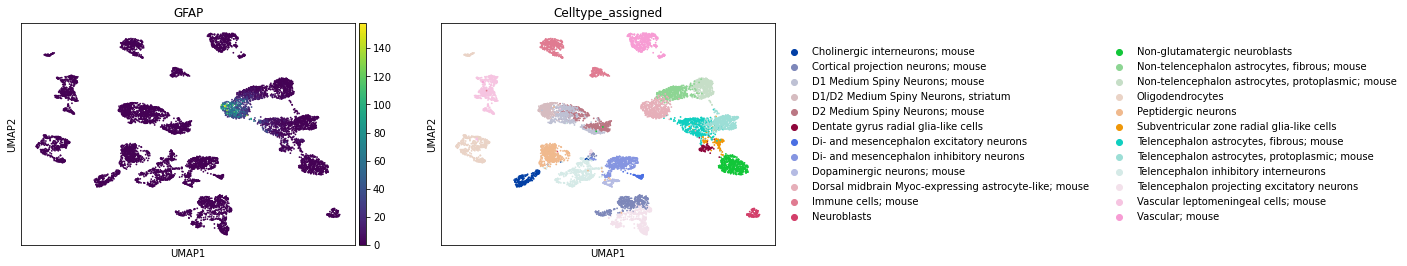

In [13]:
sc.pl.umap(adata_selected_subset, color=['GFAP', 'Celltype_assigned'])

In [46]:
export_name_subset = f'{export_name}_subset_50-500'
export_name_subset

'../../data/stereoscope_reference/single_cell_data/L5_061022/L5_CTX_M_STR_descriptionr_selection_subset_50-500'

In [47]:
adata_selected_subset.obs_names_make_unique()

/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [49]:
adata_selected_subset.write_h5ad(f'{export_name_subset}.h5ad')

In [50]:
with open(f'{export_name_subset}.pkl', 'wb') as export:
    pickle.dump(adata_selected_subset, export)